# 40k points regression

in this project I want to assess the competitive balance of the board game warhammer 40,000 by attempting to predict the 'points' cost. initially I've tracked down some base stats for what would appear to be all the models, I hope to clean that data up and try an initial (most likely poor) model, before sourcing special rule data from somewhere and seeing how that might improve things. I wont push the data used this time since I'm fairly sure at least some of it would be legally dubious...

In [35]:
# -- base packages -- #
import os
import json
from pathlib import Path
from functools import reduce

# -- data manipulation -- #
import pandas as pd
import numpy as np

# -- data visualistation -- #
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Read in Data

First challenge will be to access the data in useable form as currently its stored in many substandard jsons...

In [48]:
files = ['json_data/{}'.format(file) for file in os.listdir('json_data')]
df_list = []

for file in files:
    with open(file) as json_file:
        data = json.load(json_file)

    for unit, models in data.items():  # units contain dictionaries for each model
        if type(models) == dict:  # sometimes the unit is equal to 'error' rather than a dict :(
            for model, stats_line in models.items():  # each models stats are in another layer of dictionary
                if type(stats_line) == dict:  # sometimes the model is equal to 'error' rather than a dict :(
                    stats_line['model'] = model
                    stats_line['unit'] = unit
                    stats_line['faction'] = file.split('.')[0].split('/')[1]
                    df_list.append(pd.DataFrame(stats_line, index=[0]))
                
df = pd.concat(df_list)
df.head()

df.to_csv('json_data/full_dataset.csv', index=False)

,model_count,points_value,movement,weapon_skill,ballistic_skill,strength,toughness,wounds,attacks,leadership,save,model,unit,faction
0,1,50,"6""",2+,2+,3,3,5,4,9,3+,Canoness,Canoness,adepta-sororitas
0,1,170•,"12""",2+,2+,3,3,6,6,9,2+,Celestine,Celestine,adepta-sororitas
0,1,115•,"10""",2+,2+,3,4,7,4,9,3+,Junith Eruita,Junith Eruita,adepta-sororitas
0,1,45,"6""",4+,4+,3,3,4,3,7,6+,Missionary,Missionary,adepta-sororitas
0,1,195•,"6""",3+,3+,3,3,18,*,9,3+,Triumph of Saint Katherine,Triumph of Saint Katherine,adepta-sororitas


# Why this Dataset has been disregarded?

might do some feature generation too at this stage or might do it under a separate subheading, its currently not clear what I can be bothered with. I *would* be tempted to just regex pull all the numbers out of these stats but I'm noticed one column has one of the stats filled with a /* and I'm just wondering whether that holds some kind of meaning before I rush off to replace it with NaNs...


I googled it and it appears to mean 'variable' as there some kind of rule whereby the attacks on the model reduce as it looses HP. This will be next to impossible to effectively clean without manual intervention? I'll have to save the df and hunt the values down to fill it, with the mean attacks as we can assume they'll reduce over time. Given there are hundreds of these, and thats before we eve get to the issue of the inaccessible rules data for this datasource, I think this may be a no go zone, leading us to a second datasource I dug up whilst researching:


# Wahapedia database

I found this russian guy who's hosting the whole rules on his own deffo illegal website. to avoid bot spam, he also hosts a relational database that can be downloaded as pipe separated csvs (psvs?). This has a few issues that may need cleaning up relating to the same models that gave the prior datasource issues, but on the plus side the database also has a join we can use to access the rules for the units, meaning a fairly deep model should be buildable right out the box...(unlike miniatures, which require a shittone of glue)

In [2]:
files = ['wahapedia_database/{}'.format(file) for file in os.listdir('wahapedia_database')]

data = {Path(file).stem: pd.read_csv(file, sep='|') for file in files}  # bring files into dict with keys = filenames

for key, value in data.items():
    print('\nFor database {}'.format(key))
    print(value.columns)


For database Datasheets
Index(['id', 'name', 'link', 'faction_id', 'source_id', 'role',
       'unit_composition', 'transport', 'power_points', 'priest', 'psyker',
       'open_play_only', 'virtual', 'Cost', 'cost_per_unit', 'Unnamed: 15'],
      dtype='object')

For database Datasheets_abilities
Index(['datasheet_id', 'line', 'ability_id', 'is_index_wargear', 'cost',
       'model', 'Unnamed: 6'],
      dtype='object')

For database Datasheets_damage
Index(['datasheet_id', 'line', 'Col1', 'Col2', 'Col3', 'Col4', 'Col5',
       'Unnamed: 7'],
      dtype='object')

For database Datasheets_keywords
Index(['datasheet_id', 'keyword', 'model', 'is_faction_keyword', 'Unnamed: 4'], dtype='object')

For database Datasheets_models
Index(['datasheet_id', 'line', 'name', 'M', 'WS', 'BS', 'S', 'T', 'W', 'A',
       'Ld', 'Sv', 'Cost', 'cost_description', 'models_per_unit',
       'cost_including_wargear', 'Unnamed: 16'],
      dtype='object')


Been wanting to learn to use Path for that for a while now nice to finally use it hahaha.

so a few obvious things:
- the 'Unnamed: 0-9+' columns are all entirely empty and should be dropped
- datasheets_models would appear to be the base df for this database
- abilities is going to cause mass duplication if I just join it directly on
- I've no idea what the 'damage' database is even supposed to contain...

As a plan of attack, I think my vague idea is as follows:

1. join models to keywords
2. join the result to plain datasheets
3. join damage to it too?
4. figure a way to pull abilities through meaningfully
5. since the * models have the * replaced with 0 here, we should at least flag them so they can be removed if neccessary

I'll hopefully stumble onto any required cleaning as I go, most of it is likely to be things like removing '+' signs etc i think sice this data is meant for archiving not modelling. otherwise I dont anticipate much being outright wrong since the guy seemed pretty meticulous and has been maintaining his database for several years. Up first, the joins...:

# Prepping to join

so at first I tried just straight up joining everything but quickly realised the duplication was real, so instead it looks like im going to have to separately prep each file for joining. never as easy as it sounds ey?

the first file on the list is the **keywords** file. currently this contains the following columns:
- **datasheet_id** : the link variable
- **keyword** : a single keyword, related to the datasheet_id, meaning multiple rows per id
- **model** : appears to be the name of the model you can use to represent the unit, though is mostly NULL.
- **is_faction_keyword** : a boolean, seemingly indicating if the keyword is faction wide or specific to the unit

My plan for this is to drop model as it doesnt really benefit us at all at this stage, then create a keyword and faction keyword list. It may be that later the faction keywords get dropped in favour of just the faction name not too sure yet.

In [3]:
keywords = data['Datasheets_keywords']

faction_keywords = (
    keywords[keywords['is_faction_keyword'] == True]
    .sort_values(by=['datasheet_id', 'keyword'])  # so all models with identical keywords will have identical values
    .groupby(['datasheet_id'])['keyword']
    .apply(', '.join)  # no need for lambda here as its a base function
    .reset_index()  # to keep as df not Series
)
keywords = (
    keywords
    .sort_values(by=['datasheet_id', 'keyword'])
    .groupby('datasheet_id')['keyword']
    .apply(', '.join)
    .reset_index()
)

keywords = keywords.merge(faction_keywords, on=['datasheet_id'], how='left')
keywords.rename(columns={'keyword_x': 'keywords',
                         'keyword_y': 'faction_keywords'},
                inplace=True)

keywords.head()

,datasheet_id,keywords,faction_keywords
0,1,"<Clan>, Character, Infantry, Ork, Warboss","<Clan>, Ork"
1,2,"<Clan>, Character, Infantry, Mega Armour, Ork,...","<Clan>, Ork"
2,3,"<Clan>, Biker, Character, Ork, Speed Freeks, S...","<Clan>, Ork"
3,4,"<Clan>, Character, Infantry, Ork, Psyker, Weir...","<Clan>, Ork"
4,5,"<Clan>, Big Mek, Character, Gretchin, Grot Oil...","<Clan>, Ork"


beautiful.

next up, lets remove the shit columns from the plain old **datasheets** file. actually cleaning these columns can take place post join since I hope it'll be clearer then what we actually need and what we don't. To justify my decision to drop 'Cost' here, note that for some reason it was NaN for several of the models which have that value filled in the models file, so I'll just take the cost from there. I'm not 100% sure what some of the remaining columns are (might help if I actually knew the rules) but we can always drop more later if needs be

In [4]:
desired_columns = ['id', 'name', 'faction_id', 'role', 'transport', 'power_points',
                   'priest', 'psyker', 'open_play_only', 'virtual']
datasheets = data['Datasheets']

datasheets = datasheets[desired_columns]
datasheets.rename(columns={'id': 'datasheet_id'}, inplace=True)

datasheets.head()

C:\Users\johnc\Anaconda3\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,datasheet_id,name,faction_id,role,transport,power_points,priest,psyker,open_play_only,virtual
0,882,Custodian Guard,AC,Troops,NaN,7,NaN,NaN,False,False
1,883,Venerable Contemptor Dreadnought,AC,Elites,NaN,8,NaN,NaN,False,False
2,884,Venerable Land Raider,AC,Heavy Support,"This model can <a href=""/wh40k9ed/the-rules/co...",16,NaN,NaN,False,False
3,1446,Captain-General Trajann Valoris,AC,HQ,NaN,10,NaN,NaN,False,False
4,1447,Shield-Captain,AC,HQ,NaN,6,NaN,NaN,False,False


next, **abilities**:

I've not spoilered myself for this one yet so not too sure how it looks till we open it.

In [37]:
abilities = data['Datasheets_abilities']
abilities.head()

,datasheet_id,line,ability_id,is_index_wargear,cost,model,Unnamed: 6,has
0,1,1,2,False,NaN,NaN,NaN,1
1,1,2,3,False,NaN,NaN,NaN,1
2,1,3,2957,False,NaN,NaN,NaN,1
3,1,4,2355,False,NaN,NaN,NaN,1
4,1,5,6,False,NaN,NaN,NaN,1


oh.

I guess we wont be able to group the abilities by like type or anything like that then. I guess we'll still be able to see which ability is which by label but it's not likely these are ranked so important to make this column into categoric data type.

I guess I plan to pivot this into a binary table of dummies for each ability_id actually?

In [38]:
abilities['has'] = 1
abilities = (
    abilities
    .groupby('datasheet_id')
    .first()
    .reset_index()
    .pivot(index='datasheet_id', columns='ability_id', values='has')
    .reset_index()
    .fillna(0)
)

abilities.head()

ability_id,datasheet_id,2,55,129,140,165,191,196,263,389,...,5052,5054,5085,5126,5133,5151,5360,5387,5485,5606
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


wonderous

next up we'll take a looksee at the **damage** file. From a quick fiddle, it looks like this is the stats that are usually \*ed out for certain units. the file shows how RemainingW (wounds, hence the name 'damage' I presume?) dictates the M, S and A stats. oddly enough, looks like the columns get reassigned for every model - I hope theyre always in the same order? 

In [15]:
damage = data['Datasheets_damage']
damage.head(6)

,datasheet_id,line,Col1,Col2,Col3,Col4,Col5,Unnamed: 7
0,8,0,RemainingW,M,S,A,NaN,NaN
1,8,1,7-12,"7""",7,5,NaN,NaN
2,8,2,3-6,"6""",6,6,NaN,NaN
3,8,3,1-2,"5""",5,7,NaN,NaN
4,26,0,RemainingW,M,S,A,NaN,NaN
5,26,1,6-10,"12""",6,3,NaN,NaN


A plan of attack for this one I think might be:
- expand outwards so that we have columns for M, S, A, WS, BS, and anything else rather than he current weird unhelpful overlap
- add 'max / min' for each of M, S, A, WS, BS, etc...
- add 'number of wound thresholds' indicating row count per unit
- set M, S and A columns to equal their mean per model

In [16]:
damage = damage.groupby('datasheet_id')
damage = [data.reset_index().dropna(axis=1) for name, data in damage]  # list of dfs per id

for df in damage:
    df['datasheet_id'][0] = 'datasheet_id'
    df.drop(['index', 'line'], inplace=True, axis=1)
    df.rename(columns=df.iloc[0], inplace=True)
    df.drop(df.index[0], inplace=True)  # I'm sure this couldve been done vectorised...

damage = pd.concat(damage)
damage = damage[['datasheet_id', 'RemainingW', 'M', 'S', 'A', 'BS', 'WS']]

damage['wound_L'] = damage['RemainingW'].str.split('-').str[0].astype(int)
damage['wound_R'] = damage['RemainingW'].str.split('-').str[1].astype(int)
damage['wound_interval'] = (damage['wound_R'] + 1) - damage['wound_L']  # to weight the stats with later

damage['RemainingW'] = damage.groupby('datasheet_id')['wound_R'].transform('max')  # take the max wounds
damage['wound_thresholds'] = damage.groupby('datasheet_id')['wound_R'].transform('count')
damage.drop(['wound_L', 'wound_R'], inplace=True, axis=1)
damage = damage.reset_index()

damage['S'] = damage['S'].astype(float) * damage['wound_interval']

for col in ['M', 'A']:
    damage[col] = damage[col].str.extract('(\d+)').astype(float) 
    damage[col] = damage[col] * damage['wound_interval']  # for some reason takes group average if done on same line

for col in ['BS', 'WS']:
    damage[col] = damage[col].str.replace('+', '').astype(float) * damage['wound_interval']
    
for col in ['S', 'M', 'A', 'BS', 'WS']:
    damage[col] = (damage.groupby('datasheet_id')[col].transform('sum')) / damage['RemainingW']
    damage[col] = damage[col].replace(0, np.nan)
    damage.rename(columns={col: '{}_damage'.format(col)}, inplace=True)

damage.drop(['index', 'wound_interval', 'RemainingW'], inplace=True, axis=1)
damage.drop_duplicates(inplace=True)
damage.head()

C:\Users\johnc\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\johnc\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,datasheet_id,M_damage,S_damage,A_damage,BS_damage,WS_damage,wound_thresholds
0,8,6.333333,6.333333,5.666667,NaN,NaN,3
3,26,9.600000,5.300000,2.600000,NaN,NaN,3
6,29,20.000000,NaN,2.500000,5.5,NaN,3
9,30,20.000000,NaN,2.500000,5.5,NaN,3
12,31,20.000000,NaN,2.500000,5.5,NaN,3


well chuffed that that worked - but unfortunately this is a bit of a cop out. by taking the first digit, we get most cases correct, however there are a few cases (more than a few in the case of column A with ~200) where the value lists as 'D6' or '2+D6' etc, where D6 refers to the result of rolling a six sided dice. As such, strictly speaking these values (especially 2+D6) will be incorrect. Its faster than taking the time to manually fix each edge casse though and I'm hopeful they will be infrequent enough overall to not pose too much threat.

We now have the unenviable task of attempting to replace certain values only within the core dataset with these ones. - howdafuq?

In [39]:
df_list = [data['Datasheets_models'], datasheets, keywords, abilities, damage]

df = reduce(lambda x, y: pd.merge(x, y, on = 'datasheet_id', how='left'), df_list)  # is this still considered good practice

for col in ['S', 'M', 'A', 'BS', 'WS']:
    df[col] = df['{}_damage'.format(col)].fillna(df[col])
    df.drop('{}_damage'.format(col), inplace=True, axis=1)
    
df['wound_thresholds'].fillna(1, inplace=True)

df.to_csv('joined_wahapedia.csv', index=False)

ah thats howdafuq, supprisingly easy actually lol.

we've got some further cleaning to do before we're properly ready to start fiddling around with this that and the other but this seems like a strong start point, or at least theres no more relational database that I've no idea how best to use lol.

up next, the aforementioned cleaning i guess...

# Cleaning 

obvious things I've identified:

- the '+' sign should be ditched, numerics should be numeric
- the " sign should be ditched, numerics should be numeric
- our new average stat values are decimal whilst all others are are not, this should change
- potentially want to pivot the 'faction_keywords' column depending on how many unique values it has
- I believe some stat columns mention dice and shit instead of being numeric, this will have to be fixed
- might need to clean the 'models' file to be free of additional lines / create new ids for the extra lines or something.

shouldt hopefully take tooooooo long if we do it in order I guess...

In [25]:
m_map = {'6+D6': '9',
         '-': '0',
         '15-30': '22.5',
         '20-30': '25',
         '20-60': '40'}

df['M'] = df['M'].str.replace('"', '').replace(m_map).astype(float)
df['S'] = df['S'].str.replace('-', '0').astype(float)
df['W'] = df['W'].str.replace('-', '0').astype(float)
df['BS'] = df['BS'].str.replace('+', '').str.replace('-', '0').astype(float)
df['WS'] = df['WS'].str.replace('+', '').str.replace('-', '0').astype(float)

C:\Users\johnc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\johnc\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()


alright thats most of those points hit, lets have a nosey at the unique values in faction keywords.

In [34]:
keywords = list(set(list(', '.join(df['faction_keywords'].unique()).split(', '))))

for keyword in keywords:
    df[keyword] = np.where(df['faction_keywords'].str.contains(keyword), 1, 0)

very norty indeed. ok, lets just be sure theres no errant NaNs.

<AxesSubplot:>

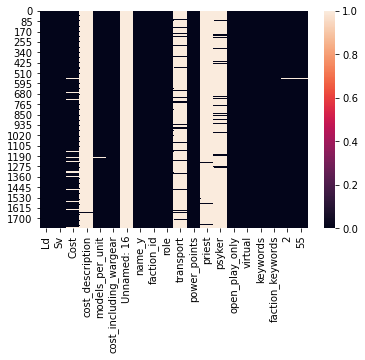

In [38]:
sns.heatmap(df[df.columns[10:30]].isnull())

concerning to see cost have NULLs, I'll have to at least drop those rows. there are few entire columns that will also need droppingbut nothing hugely concerning elsewhere

<AxesSubplot:>

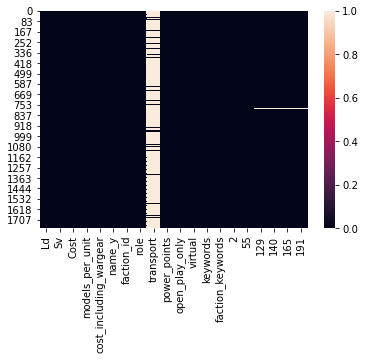

In [42]:
df.drop(['cost_description', 'Unnamed: 16', 'psyker', 'priest'], axis=1, inplace=True)
df['models_per_unit'].fillna(1, inplace=True)

for col in df.columns[24:]:
    df[col].fillna(0, inplace=True)

df.dropna(subset=['Cost'], inplace=True)

sns.heatmap(df[df.columns[10:30]].isnull())

finally transport. what does that column even contain?

In [44]:
df['transport'].unique()[:5]

array([nan,
       'This model can <a href="/wh40k9ed/the-rules/core-rules/#Transports">transport</a> 12 <span class="tooltip" data-tooltip-content="#tooltip_content02027" data-tooltip-anchor="#tooltip_content02027"><span class="kwb">FLASH</span> <span class="kwb">GITZ</span></span> or <span class="tooltip" data-tooltip-content="#tooltip_content02028" data-tooltip-anchor="#tooltip_content02028"><span class="kwb2">&lt;<span class="kwb3">C</span>LAN&gt;</span> <span class="kwb">INFANTRY</span></span> models. Each <span class="tooltip" data-tooltip-content="#tooltip_content02029" data-tooltip-anchor="#tooltip_content02029"><span class="kwb">MEGA</span> <span class="kwb">ARMOUR</span></span> or <span class="tooltip" data-tooltip-content="#tooltip_content02030" data-tooltip-anchor="#tooltip_content02030"><span class="kwb">JUMP</span> <span class="kwb">PACK</span></span> model takes the space of two other models.',
       'This model can <a href="/wh40k9ed/the-rules/core-rules/#Transports">t

ah shit why do bad things happen to good people.

so two options: 

- replace with a binary transport yes or no
- replace with a number of people that can be transported by this column using some kind of regex to get at the first number after the first \<a\> node
    


In [45]:
df['number_in_transport'] = df['transport'].str.extract(r'(?:transport</a>)(\d+)').fillna(0)
df['transport'] = np.where(df['transport'].isnull(), 0, 1)

df.to_csv('joined_wahapedia.csv', index=False)

# Prepping for modelling

okie dokie, so should be able to break this up and attempt our first model now? it seems to all be working at least. First things first lets do some correlation checks, variable importance sampling etc... in order to determine which features we might want to use...

In [24]:
df = pd.read_csv('joined_wahapedia.csv')